# Simulating Hierarchical Bayesian Reinforcement Learning


Simulated example to illustrate the success of the methodology.

The same as before, however now $10$ individuals have their parameters sampled the population distributions:

$$\alpha^i \sim $$

----

```
author:    Zach Wolpe
email:     zachcolinwolpe@gmail.com
reviewer:  na
date:      04 January 2022
```

----

In [141]:
%%capture
!pip upgrade arviz==0.6.1
!pip install git+https://github.com/pymc-devs/pymc3
!pip install git+git://github.com/arviz-devs/arviz.git


In [5]:
!conda install -c conda-forge pymc3 -y


Solving environment: done

# All requested packages already installed.



In [6]:
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import math
import pymc3 as pm
from tqdm import tqdm
import theano
import theano.tensor as tt
import arviz as az

TypeError: data type 'float128' not understood

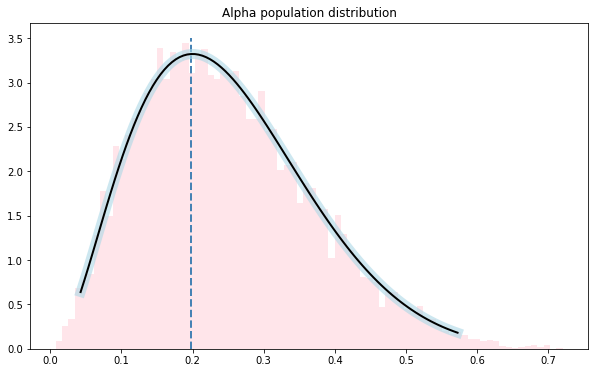

In [4]:
# alpha population distribution ------------------------------*
# params
a,b = 3,9

# distribution
mean, var, skew, kurt = stats.beta.stats(a,b, moments='mvsk')
x = np.linspace(stats.beta.ppf(0.01, a, b),
                stats.beta.ppf(0.99, a, b), 100)
y = stats.beta.pdf(x, a, b)

# random sample
rv = stats.beta(a, b)
r  = rv.rvs(size=10000)

# vis 
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(x, y, 'lightblue', lw=10, alpha=0.6, label='beta pdf')
ax.plot(x, y, 'k-', lw=2, label='frozen pdf')
ax.hist(r, bins=80, density=True, color='pink', histtype='stepfilled', alpha=0.4)
ax.vlines(x=x[np.where(y==max(y))], ymin=0, ymax=3.5, lw=2, color='steelblue', linestyles='dashed')
plt.title('Alpha population distribution')
plt.show()
# alpha population distribution ------------------------------*

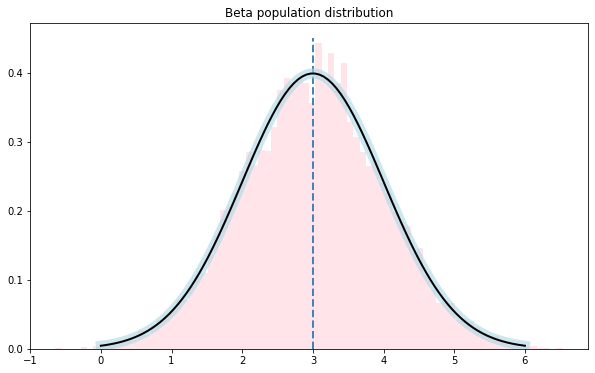

In [5]:
# beta population distribution -------------------------------*
# params
mu        = 3
variance  = 1

# distribution
sigma = math.sqrt(variance)
x     = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
y     = stats.norm.pdf(x, mu, sigma)

# random sample
rv = stats.norm(mu, sigma)
r  = rv.rvs(size=10000)

# vis 
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(x, y, 'lightblue', lw=10, alpha=0.6, label='alpha pdf')
ax.plot(x, y, 'k-', lw=2, label='frozen pdf')
ax.hist(r, bins=80, density=True, color='pink', histtype='stepfilled', alpha=0.4)
ax.vlines(x=mu, ymin=0, ymax=0.45, lw=2, color='steelblue', linestyles='dashed')
plt.title('Beta population distribution')
plt.show()
# beta population distribution -------------------------------*

# Generate Subject Data

In [6]:
%%time
# sample population distributions ------------------------------------------*
n_samples = 100
subject_betas  = stats.norm(loc=mu, scale=sigma).rvs(n_samples)
subject_alphas = stats.beta(a, b).rvs(n_samples)

CPU times: user 3.09 ms, sys: 0 ns, total: 3.09 ms
Wall time: 2.97 ms


In [7]:
# DGP ----------------------------------------------------------------------*
def data_generating_process(alpha, beta, n=100, p_r=[.8, .6, .7]):
  actions = np.zeros(n, dtype=np.int)
  rewards = np.zeros(n, dtype=np.int)
  Qs      = np.zeros((n, 3))

  # Q init
  Q = np.array(len(p_r)*[1/len(p_r)])

  for i in tqdm(range(n)):
    # P(a|Q): Apply Boltzmann distribution
    exp_Q = np.exp(beta*Q)
    pi_a  = exp_Q / np.sum(exp_Q)


    # Simulate action-reward
    a = np.random.choice([0,1,2], p=pi_a)
    r = np.random.rand() < p_r[a]

    # Update Qt(a) = Qt-1(a) + a[RPE]
    Q[a] = Q[a] + alpha * (r - Q[a])

    # store
    actions[i] = a
    rewards[i] = r
    Qs[i] = Q.copy()

  return actions, rewards, Qs  

In [ ]:
# store as a dict
n = 100
data = {}
for i, theta in enumerate(zip(subject_alphas, subject_betas)):
  actions, rewards, Qs = data_generating_process(alpha=theta[0], beta=theta[1], n=n)
  data['subject_'+str(i)] = {'actions': actions, 'rewards':rewards, 'true_alpha':theta[0], 'true_beta':theta[1], 'Qs':Qs}

# Method I: Summary Statistics

As a baseline point of comparison, one can use the niave method of fitting all subjects independently & then use thier estimates as samples from the population to estimate the population distribution. This is referred to as the summary statistics approach.

## Fit

Here we fit all $10$ models independently.

In [ ]:
%%time
# Bayes RL  ==================================================================================================================================*

# each subject
for i in tqdm(range(n_samples)):
  actions = data['subject_'+str(i)]['actions']
  rewards = data['subject_'+str(i)]['rewards']

  with pm.Model() as bayesian_reinforcement_learning:

    # data
    actions_  = pm.Data('actions', actions)
    rewards_  = pm.Data('rewards', rewards)

    # priors
    alpha = pm.Beta('alpha', 1, 1)
    beta  = pm.HalfNormal('beta', 10)

    # model 
    # init Qs
    Qs = 0.3333 * tt.ones(3, dtype='float64')

    # Compute the Q values for each trial
    Qs, _ = theano.scan(
        fn=lambda action, reward, Qs, alpha: tt.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action])),
        sequences=[actions_, rewards_],
        outputs_info=[Qs],
        non_sequences=[alpha])


    BQs = beta*Qs
    pi =  tt.nnet.softmax(BQs)
    like = pm.Categorical('like', p=pi, observed=actions_)

    # opt
    trace = pm.sample(tune=1000, chains=2, target_accept=0.85) # tune=5000, target_accept=0.9 njobs=4 ,target_accept=0.99
    idata = az.from_pymc3(trace)
    pm.traceplot(idata)


    # store estimates
    data['subject_'+str(i)]['trace'] = trace
    data['subject_'+str(i)]['idata'] = idata
  # Bayes RL  ==================================================================================================================================*


-----

# Summary Statistics Distribution

Now we simple use the estimates as independent samples to fit the distributions:

$$\alpha \sim \mathcal{beta}(a_{\alpha}, b_{\alpha}), \; \; \;  \beta \sim \mathcal{N}(\mu_{\beta}, \sigma_{\beta})$$


In [156]:

true_alphas   = []
true_betas    = []
approx_alpha  = []
approx_beta   = []

for i in range(10):
  true_alphas.append(data['subject_'+str(i)]['true_alpha'])
  true_betas.append(data['subject_'+str(i)]['true_beta'])
  # approx_alpha.append(data['subject_'+str(i)]['trace']['alpha'])
  # approx_beta.append(data['subject_'+str(i)]['trace']['beta'])
  # means 
  approx_alpha.append(data['subject_'+str(i)]['trace']['alpha'].mean())
  approx_beta.append(data['subject_'+str(i)]['trace']['beta'].mean())


In [157]:
trace['alpha'].std()

0.06007944915605776

In [132]:
data['subject_'+str(i)]['trace']['alpha'].mean()

0.17771872426955176

In [178]:
# https://stats.stackexchange.com/questions/68983/beta-distribution-fitting-in-scipy
a_al_true, b_al_true, loc_al_true, scale_al_true = stats.beta.fit(true_alphas, floc=0, fscale=1)
a_al_aprx, b_al_aprx, loc_al_aprx, scale_al_aprx = stats.beta.fit(approx_alpha, floc=0, fscale=1)

beta_true_mu, beta_true_std = stats.norm.fit(true_betas)
beta_aprx_mu, beta_aprx_std = stats.norm.fit(approx_beta)


In [179]:
beta_true_mu, beta_true_std, beta_aprx_mu, beta_aprx_std

(3.108770229597089, 0.9595894475151323, 3.4020817685092277, 1.1838876850803135)

In [180]:
for i, j in zip(['a', 'b', 'loc', 'scale'], [a_al_true, b_al_true, loc_al_true, scale_al_true]):
  print(i, ': ', str(round(j,2)))

print('-----')
for i, j in zip(['a', 'b', 'loc', 'scale'], [a_al_aprx, b_al_aprx, loc_al_aprx, scale_al_aprx]):
  print(i, ': ', str(round(j,2)))


a :  4.56
b :  10.27
loc :  0
scale :  1
-----
a :  2.09
b :  3.86
loc :  0
scale :  1


# Assess Fit: Summary Statistics Method

**COMPLETELY FAILED TO CONVERGE**

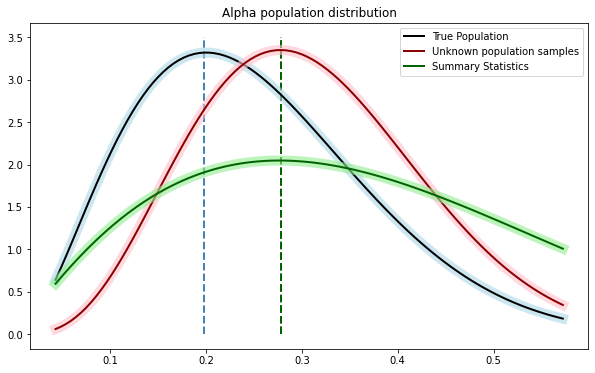

In [191]:
# alpha population distribution ------------------------------*
# params
a,b = 3,9

# distribution
mean, var, skew, kurt = stats.beta.stats(a,b, moments='mvsk')
x = np.linspace(stats.beta.ppf(0.01, a, b),
                stats.beta.ppf(0.99, a, b), 100)
y = stats.beta.pdf(x, a, b)

# random sample
rv = stats.beta(a, b)
r  = rv.rvs(size=10000)

# vis 
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(x, y, 'lightblue', lw=10, alpha=0.6)
ax.plot(x, y, 'k-', lw=2, label='True Population')
ax.vlines(x=x[np.where(y==max(y))], ymin=0, ymax=3.5, lw=2, color='steelblue', linestyles='dashed')

# fit (unknown) true sample values
rv_alpha_true = stats.beta(a=a_al_true, b=b_al_true, loc=loc_al_true, scale=scale_al_true).pdf(x)
ax.plot(x, rv_alpha_true, 'pink', lw=10, alpha=0.6)
ax.plot(x, rv_alpha_true, 'k-', lw=2, color='darkred', label='Unknown population samples')
ax.vlines(x=x[np.where(rv_alpha_true==max(rv_alpha_true))], ymin=0, ymax=3.5, lw=2, color='darkred', linestyles='dashed')

# fit approx values 
rv_alpha_aprx = stats.beta(a_al_aprx, b_al_aprx, loc_al_aprx, scale_al_aprx).pdf(x)
ax.plot(x, rv_alpha_aprx, 'lightgreen', lw=10, alpha=0.6)
ax.plot(x, rv_alpha_aprx, 'k-', lw=2, color='darkgreen', label='Summary Statistics')
ax.vlines(x=x[np.where(rv_alpha_aprx==max(rv_alpha_aprx))], ymin=0, ymax=3.5, lw=2, color='darkgreen', linestyles='dashed')


plt.title('Alpha population distribution')
plt.legend()
plt.show()
# alpha population distribution ------------------------------*

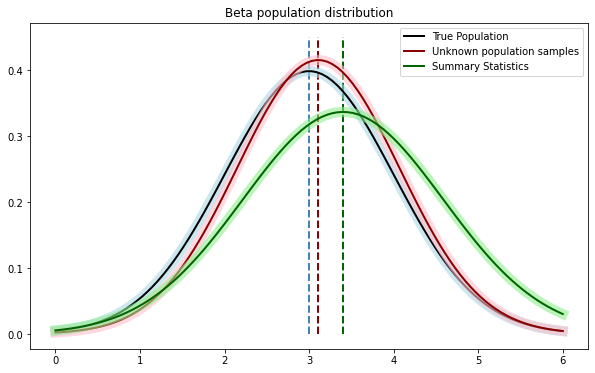

In [194]:
# beta population distribution -------------------------------*
# params
mu        = 3
variance  = 1

# distribution
sigma = math.sqrt(variance)
x     = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
y     = stats.norm.pdf(x, mu, sigma)

# random sample
# rv = stats.norm(mu, sigma)
# r  = rv.rvs(size=10000)

# vis 
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(x, y, 'lightblue', lw=10, alpha=0.6)
ax.plot(x, y, 'k-', lw=2, label='True Population')
# ax.hist(r, bins=80, density=True, color='pink', histtype='stepfilled', alpha=0.4)
ax.vlines(x=mu, ymin=0, ymax=0.45, lw=2, color='steelblue', linestyles='dashed')


# fit (unknown) true sample values
rv_beta_true = stats.norm(beta_true_mu, beta_true_std).pdf(x)
ax.plot(x, rv_beta_true, 'pink', lw=10, alpha=0.6)
ax.plot(x, rv_beta_true, 'k-', lw=2, color='darkred', label='Unknown population samples')
ax.vlines(x=beta_true_mu, ymin=0, ymax=0.45, lw=2, color='darkred', linestyles='dashed')

# fit approx values 
rv_beta_apprx = stats.norm(beta_aprx_mu, beta_aprx_std).pdf(x)
ax.plot(x, rv_beta_apprx, 'lightgreen', lw=10, alpha=0.6)
ax.plot(x, rv_beta_apprx, 'k-', lw=2, color='darkgreen', label='Summary Statistics')
ax.vlines(x=beta_aprx_mu, ymin=0, ymax=0.45, lw=2, color='darkgreen', linestyles='dashed')

plt.title('Beta population distribution')
plt.legend()
plt.show()
# beta population distribution -------------------------------*

----

# Hierarchical Bayesian RL

Fitting an Hierarchical Bayesian RL model.

[reference](https://docs.pymc.io/en/v3/pymc-examples/examples/generalized_linear_models/GLM-hierarchical.html)

In [3]:
%%capture
%%time
!pip upgrade arviz==0.6.1
!pip install git+https://github.com/pymc-devs/pymc3
!pip install git+git://github.com/arviz-devs/arviz.git

In [2]:
from scipy import stats
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import math
import pymc3 as pm
import pandas as pd
from tqdm import tqdm
import theano
import theano.tensor as tt
import arviz as az

In [9]:
data['subject_0'].keys()

dict_keys(['actions', 'rewards', 'true_alpha', 'true_beta', 'Qs'])

In [10]:
n_samples

100

In [ ]:
# Convert to table data structure -------------*
%%time
if 'df' in globals(): del df

for subject in tqdm(data.keys()):
  if 'df' not in globals():
    df = pd.DataFrame({
        'subject' : [subject] * n_samples, 
        'actions' : data[subject]['actions'],
        'true_alpha' : data[subject]['true_alpha'] * n_samples,
        'true_beta' : data[subject]['true_beta'] * n_samples
        })
  else:
    df = df.append(df, ignore_index=False)

df.shape

 11%|█         | 11/100 [00:16<00:00, 100.82it/s]

In [ ]:
%%time
# Bayes RL  ==================================================================================================================================*

# each subject
for i in tqdm(range(n_samples)):
  actions = data['subject_'+str(i)]['actions']
  rewards = data['subject_'+str(i)]['rewards']

  with pm.Model() as bayesian_reinforcement_learning:

    # data
    actions_  = pm.Data('actions', actions)
    rewards_  = pm.Data('rewards', rewards)

    # priors
    alpha = pm.Beta('alpha', 1, 1)
    beta  = pm.HalfNormal('beta', 10)

    # model 
    # init Qs
    Qs = 0.3333 * tt.ones(3, dtype='float64')

    # Compute the Q values for each trial
    Qs, _ = theano.scan(
        fn=lambda action, reward, Qs, alpha: tt.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action])),
        sequences=[actions_, rewards_],
        outputs_info=[Qs],
        non_sequences=[alpha])


    BQs = beta*Qs
    pi =  tt.nnet.softmax(BQs)
    like = pm.Categorical('like', p=pi, observed=actions_)

    # opt
    trace = pm.sample(tune=1000, chains=2, target_accept=0.85) # tune=5000, target_accept=0.9 njobs=4 ,target_accept=0.99
    idata = az.from_pymc3(trace)
    pm.traceplot(idata)


    # store estimates
    data['subject_'+str(i)]['trace'] = trace
    data['subject_'+str(i)]['idata'] = idata
  # Bayes RL  ==================================================================================================================================*